# This Notebook is my try to implement "Learning Not To Learn" paper

### Loading Modules

In [1]:
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import random
import torch.optim as optim
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
data = datasets.mnist.MNIST("./",download = True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.69MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 13.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.5MB/s]


In [3]:
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [4]:
device = torch.device("cuda")
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

### Generation of random colors and assigning them to digits

In [5]:
random_colors = np.random.randint(255,size=(10,3))
digits_mean_color = np.arange(0,10)
np.random.shuffle(digits_mean_color)

In [6]:
data.data.shape[0]

60000

### Showing an image from the dataset

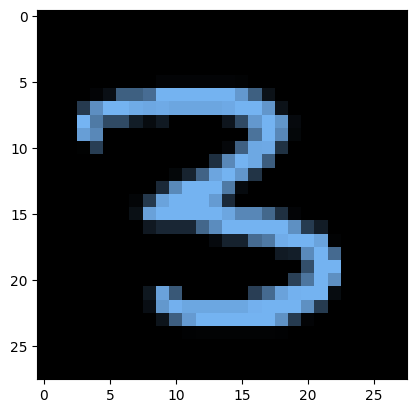

In [8]:
color = (random_colors[digits_mean_color[7]] + np.random.normal(0,20,size=(3)))
color = np.clip(color,0,255)
gray = data.data[40578].float()/255.0
colored_digit = (gray.view(1,28,28)*(torch.from_numpy(color).float().view(3,1,1))/255.0)
plt.imshow(colored_digit.permute(1, 2, 0))

### Loading the dataset
#### For each item we get the image, label, bias
#### First we inject the color bias into data
#### then return the biased image, label, bias_red, bias_green, bias_blue

In [9]:
class TrainDataset(Dataset):
    def __init__(self, training_size, data, random_colors=random_colors, mean_colors = digits_mean_color):
        self.data = data
        self.size = training_size
        self.random_colors = random_colors
        self.mean_colors = mean_colors
        
    def __len__(self):
        return self.size

    def __getitem__(self, index):
        gray_image = data.data[index].float()/255.0
        label = data.targets[index]   
        current_mean_color = self.mean_colors[label]
        color= np.random.normal(self.random_colors[current_mean_color],30,size=(3))
        color = np.clip(color,0,255)
        color_red = int(color[0] / 32)
        color_green = int(color[1] /32)
        color_blue = int(color[2] /32)
        colored_image = (gray_image.view(1,28,28)*(torch.from_numpy(color).float().view(3,1,1))/255.0)
        return (colored_image,label,color_red,color_green,color_blue)


training_size = int(0.9*data.data.shape[0])
train_dataset = TrainDataset(training_size=training_size, data = data)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

### The same is done for testing dataset, However the color injected is choosen randomly

In [10]:
class TestDataset(Dataset):
    def __init__(self, training_size, data, random_colors=random_colors, mean_colors = digits_mean_color):
        self.data = data
        self.size = training_size
        self.random_colors = random_colors
        self.mean_colors = mean_colors
        
    def __len__(self):
        return data.data.shape[0] - self.size

    def __getitem__(self, index):

        index = index + self.size
        
        gray_image = self.data.data[index].float()/255.0
        label = data.targets[index] 
        color_label = random.randint(0,9)
        color= np.random.normal(self.random_colors[color_label],30,size=(3))
        color = np.clip(color,0,255)
        color_red = int(color[0] / 32)
        color_green = int(color[1] /32)
        color_blue = int(color[2] /32)
        colored_image = (gray_image.view(1,28,28)*(torch.from_numpy(color).float().view(3,1,1))/255.0)
        return (colored_image,label,color_red,color_green,color_blue)

test_dataset = TestDataset(training_size=training_size, data = data)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=2)

### In the paper the architecture specified is two conv layers for each part. 
* Two for f (Main stem).
* Two for g (main head for classifying digits).
* Two for h (for classifying each bias label)

### Baseline Model

In [11]:

class Convy_base(nn.Module):
    def __init__(self, input_channels=3, dim=28, num_classes=10):
        super(Convy_base, self).__init__()
        
        self.conv1f = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.batchNorm1f = nn.BatchNorm2d(16)
        self.conv2f = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.batchNorm2f = nn.BatchNorm2d(32)
        
        
        self.conv1g = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.batchNorm1g = nn.BatchNorm2d(64)
        self.conv2g = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.batchNorm2g = nn.BatchNorm2d(64)
        self.fc_g = nn.Linear(64, num_classes)  


        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.soft = torch.nn.Softmax(dim = 1)
        

    
    def forward(self, img):
        f = self.pool(self.relu(self.batchNorm1f(self.conv1f(img))))
        f = self.pool(self.relu(self.batchNorm2f(self.conv2f(f))))

        g = self.relu(self.conv1g(f))
        g = self.pool(self.relu(self.conv2g(g)))
        g = g.view(g.size(0), -1)
        g = self.fc_g(g)
        

        return g

    def predict_number(self, img):
        f = self.pool(self.relu(self.batchNorm1f(self.conv1f(img))))
        f = self.pool(self.relu(self.batchNorm2f(self.conv2f(f))))

        g = self.relu(self.conv1g(f))
        g = self.pool(self.relu(self.conv2g(g)))
        g = g.view(g.size(0), -1)
        g = self.fc_g(g)
        

        return g
        


In [12]:
model_base = Convy_base()
optimizer_base = optim.Adam(model_base.parameters(), lr=1e-3,weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

In [13]:
max_acc_base = 0

In [14]:
def evaluate(model, dataloader, device='cuda'):
    model.eval()
    correct = total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch, _, _, _ in dataloader:
            x_batch = x_batch.to(device, torch.float32)
            y_batch = y_batch.to(device)

            
            logits = model.predict_number(x_batch)  
            probs = torch.softmax(logits, dim=1)  
            preds = torch.argmax(probs, dim=1)  


            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)


            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())


    accuracy = 100.0 * correct / total 
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, f1


In [15]:

def train(train_dataloader):
    number_of_samples = 0
    batch_loss = 0
    batch_loss_pred=0
    model_base.to(device)
    model_base.train()

    for batch_idx, (input, target_label, _, _, _) in enumerate(train_dataloader):
        input, target_label = input.to(device), target_label.to(device)


        optimizer_base.zero_grad()
        outputs = model_base(input)
        loss_main = criterion(outputs, target_label)
        loss_main.backward()
        optimizer_base.step()

        number_of_samples += 1
        batch_loss += loss_main.item()

    return batch_loss


for _ in range(20):
    train_batches_error = []
    train(train_dataloader)
    test_acc, train_f1= evaluate(model_base, test_dataloader)
    print(test_acc)
    if test_acc > max_acc_base:
        max_acc_base = test_acc
        torch.save(model_base.state_dict(), "best_model_mnist_base.pt")


53.05
56.06666666666667
60.86666666666667
63.35
59.4
60.63333333333333
64.21666666666667
63.45
60.95
62.88333333333333
61.733333333333334
64.36666666666666
68.36666666666666
62.6
65.55
64.9
65.56666666666666
65.01666666666667
63.93333333333333
62.06666666666667


#### Maximum Accuracy from the baseline model

In [16]:
model_base.load_state_dict(torch.load("/kaggle/working/best_model_mnist_base.pt"))
evaluate(model_base,test_dataloader)[0]

68.05

#### Base Model Confusion Matrix

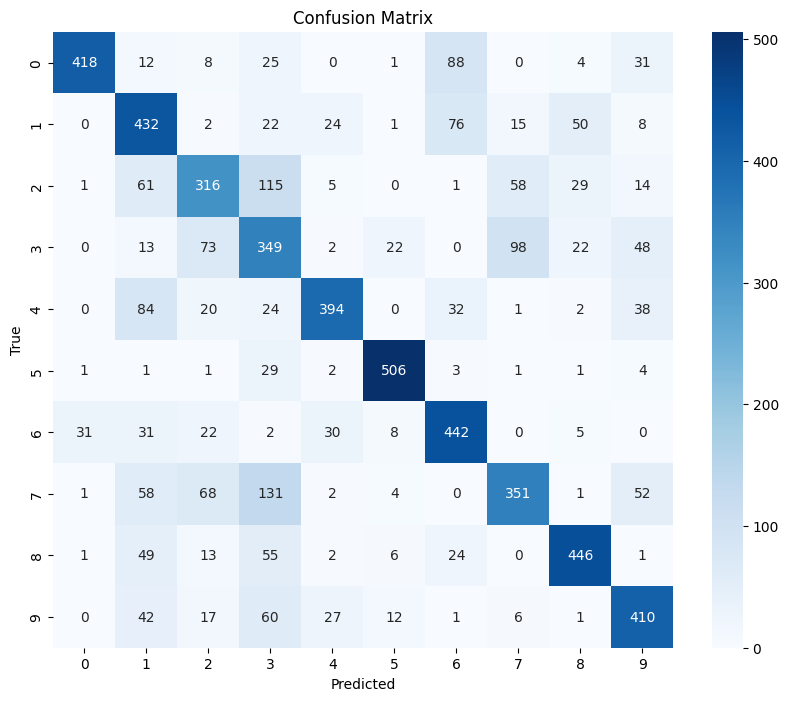

In [42]:
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        images, labels, _, _, _ = batch  
        images, labels = images.to(device), labels.to(device)
        
        # Get predictions using predict_number
        outputs = model_base.predict_number(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


cm = confusion_matrix(all_labels, all_preds)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [17]:

class Convy(nn.Module):
    def __init__(self, input_channels=3, dim=28, num_classes=10):
        super(Convy, self).__init__()
        
        self.conv1f = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.batchNorm1f = nn.BatchNorm2d(16)
        self.conv2f = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.batchNorm2f = nn.BatchNorm2d(32)
        
        
        self.conv1g = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.batchNorm1g = nn.BatchNorm2d(64)
        self.conv2g = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.batchNorm2g = nn.BatchNorm2d(64)
        self.fc_g = nn.Linear(64, num_classes)  

        
        self.conv1h_r = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size = 3)
        self.batchNorm1h_r = nn.BatchNorm2d(64)
        self.conv2h_r = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size = 3)
        self.batchNorm2h_r = nn.BatchNorm2d(64)
        self.fc_h_r = nn.Linear(64, 8)


        self.conv1h_g = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size = 3)
        self.batchNorm1h_g = nn.BatchNorm2d(64)
        self.conv2h_g = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size = 3)
        self.batchNorm2h_g = nn.BatchNorm2d(64)
        self.fc_h_g = nn.Linear(64, 8)


        self.conv1h_b = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size = 3)
        self.batchNorm1h_b = nn.BatchNorm2d(64)
        self.conv2h_b = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size = 3)
        self.batchNorm2h_b = nn.BatchNorm2d(64)
        self.fc_h_b = nn.Linear(64, 8)

        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.soft = torch.nn.Softmax(dim = 1)
        

    def f_parameters(self):
        return list(self.conv1f.parameters()) + list(self.conv2f.parameters())

    def g_parameters(self):
        return list(self.conv1g.parameters()) + list(self.conv2g.parameters()) + list(self.fc_g.parameters())

    def h_parameters(self):
        return list(self.conv1h_r.parameters()) + list(self.conv2h_r.parameters()) + list(self.fc_h_r.parameters())+list(self.conv1h_g.parameters()) + list(self.conv2h_g.parameters()) + list(self.fc_h_g.parameters())+list(self.conv1h_b.parameters()) + list(self.conv2h_b.parameters()) + list(self.fc_h_b.parameters())

        
    def forward(self, img):
        f = self.pool(self.relu(self.batchNorm1f(self.conv1f(img))))
        f = self.pool(self.relu(self.batchNorm2f(self.conv2f(f))))

        g = self.relu(self.conv1g(f))
        g = self.pool(self.relu(self.conv2g(g)))
        g = g.view(g.size(0), -1)
        g = self.fc_g(g)

        h = self.relu(self.conv1h(f))
        h = self.pool(self.relu(self.conv2h(h)))
        h = h.view(h.size(0), -1)
        h = self.fc_h(h)
        

        return g,h
        

    def predict_number(self,img):
        f = self.pool(self.relu(self.batchNorm1f(self.conv1f(img))))
        f = self.pool(self.relu(self.batchNorm2f(self.conv2f(f))))

        g = self.relu(self.batchNorm1g(self.conv1g(f)))
        g = self.pool(self.relu(self.batchNorm2g(self.conv2g(g))))
        g = g.view(g.size(0), -1)
        g = self.fc_g(g)

        return g

    
    def predict_bias_inv_r(self,img):
        f = self.pool(self.relu(self.batchNorm1f(self.conv1f(img))))
        f = self.pool(self.relu(self.batchNorm2f(self.conv2f(f))))
        
        f = GradientReversal.apply(f)

        h = self.relu(self.batchNorm1h_r(self.conv1h_r(f)))
        h = self.pool(self.relu(self.batchNorm2h_r(self.conv2h_r(h))))
        h = h.view(h.size(0), -1)
        h = self.fc_h_r(h)

        return h

    def predict_bias_r(self,img):
        f = self.pool(self.relu(self.batchNorm1f(self.conv1f(img))))
        f = self.pool(self.relu(self.batchNorm2f(self.conv2f(f))))

        h = self.relu(self.batchNorm1h_r(self.conv1h_r(f)))
        h = self.pool(self.relu(self.batchNorm2h_r(self.conv2h_r(h))))
        h = h.view(h.size(0), -1)
        h = self.fc_h_r(h)

        return h

    def predict_bias_inv_g(self,img):
        f = self.pool(self.relu(self.batchNorm1f(self.conv1f(img))))
        f = self.pool(self.relu(self.batchNorm2f(self.conv2f(f))))
        
        f = GradientReversal.apply(f)

        h = self.relu(self.batchNorm1h_g(self.conv1h_g(f)))
        h = self.pool(self.relu(self.batchNorm2h_g(self.conv2h_g(h))))
        h = h.view(h.size(0), -1)
        h = self.fc_h_g(h)

        return h

    def predict_bias_g(self,img):
        f = self.pool(self.relu(self.batchNorm1f(self.conv1f(img))))
        f = self.pool(self.relu(self.batchNorm2f(self.conv2f(f))))

        h = self.relu(self.batchNorm1h_g(self.conv1h_g(f)))
        h = self.pool(self.relu(self.batchNorm2h_g(self.conv2h_g(h))))
        h = h.view(h.size(0), -1)
        h = self.fc_h_g(h)

        return h

    def predict_bias_inv_b(self,img):
        f = self.pool(self.relu(self.batchNorm1f(self.conv1f(img))))
        f = self.pool(self.relu(self.batchNorm2f(self.conv2f(f))))
        
        f = GradientReversal.apply(f)

        h = self.relu(self.batchNorm1h_b(self.conv1h_b(f)))
        h = self.pool(self.relu(self.batchNorm2h_b(self.conv2h_b(h))))
        h = h.view(h.size(0), -1)
        h = self.fc_h_b(h)

        return h

    def predict_bias_b(self,img):
        f = self.pool(self.relu(self.batchNorm1f(self.conv1f(img))))
        f = self.pool(self.relu(self.batchNorm2f(self.conv2f(f))))

        h = self.relu(self.batchNorm1h_b(self.conv1h_b(f)))
        h = self.pool(self.relu(self.batchNorm2h_b(self.conv2h_b(h))))
        h = h.view(h.size(0), -1)
        h = self.fc_h_b(h)
        return h
        
        
        
class GradientReversal(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        return -grad_output


In [36]:
model = Convy()

In [37]:
max_acc = 0

In [38]:
optimizer_f = optim.Adam(model.f_parameters(), lr=1e-3,weight_decay=1e-3)
optimizer_g = optim.Adam(model.g_parameters(), lr=1e-3,weight_decay=1e-3)
optimizer_h = optim.Adam(model.h_parameters(), lr=1e-3,weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

In [39]:

def train(train_dataloader,lambda_,mu):
    number_of_samples = 0
    batch_loss = 0
    batch_loss_pred=0
    model.to(device)
    model.train()

    for batch_idx, (input, target_label, bias_red, bias_green, bias_blue) in enumerate(train_dataloader):
        input, target_label, bias_red, bias_green, bias_blue = input.to(device), target_label.to(device), bias_red.to(device), bias_green.to(device), bias_blue.to(device)

        optimizer_h.zero_grad()
        optimizer_f.zero_grad()
        bias_preds_red = model.predict_bias_inv_r(input)
        bias_preds_green = model.predict_bias_inv_g(input)
        bias_preds_blue = model.predict_bias_inv_b(input)
        loss_bias_h_r = criterion(bias_preds_red, bias_red)
        loss_bias_h_g = criterion(bias_preds_green, bias_green)
        loss_bias_h_b = criterion(bias_preds_blue, bias_blue)
        loss_bias_h = (loss_bias_h_r + loss_bias_h_g + loss_bias_h_b)*(mu/3)
        loss_bias_h.backward()
        optimizer_h.step()
        optimizer_f.step()

        
        optimizer_f.zero_grad()
        bias_probs_r = F.softmax(model.predict_bias_r(input), dim=1)
        entropy_r = torch.sum(bias_probs_r * torch.log(bias_probs_r + 1e-8), dim=1).mean()
        loss_entropy_r = lambda_ * entropy_r

        bias_probs_g = F.softmax(model.predict_bias_g(input), dim=1)
        entropy_g = torch.sum(bias_probs_g * torch.log(bias_probs_g + 1e-8), dim=1).mean()
        loss_entropy_g = lambda_ * entropy_g

        bias_probs_b = F.softmax(model.predict_bias_b(input), dim=1)
        entropy_b = torch.sum(bias_probs_b * torch.log(bias_probs_b+ 1e-8), dim=1).mean()
        loss_entropy_b = lambda_ * entropy_b
 
        loss_entropy = (loss_entropy_r + loss_entropy_g + loss_entropy_b) / 3
        loss_entropy.backward()
        optimizer_f.step()


        optimizer_f.zero_grad()
        optimizer_g.zero_grad()
        outputs = model.predict_number(input)
        loss_main = criterion(outputs, target_label)
        loss_main.backward()
        optimizer_f.step()
        optimizer_g.step()

        number_of_samples += 1
        batch_loss += loss_main.item() + loss_bias_h.item() + loss_entropy.item()
        batch_loss_pred += loss_main.item()

    return batch_loss, batch_loss_pred


for _ in range(20):
    train_batches_error = []
    train(train_dataloader,0.005,0.1)
    test_acc, train_f1= evaluate(model, test_dataloader)
    print(test_acc)
    if test_acc > max_acc:
        max_acc = test_acc
        torch.save(model.state_dict(), "best_model_mnist.pt")


69.85
67.13333333333334
76.26666666666667
82.06666666666666
74.4
80.06666666666666
84.26666666666667
87.33333333333333
79.86666666666666
82.15
78.8
79.53333333333333
82.96666666666667
83.96666666666667
89.46666666666667
84.96666666666667
79.26666666666667
83.96666666666667
76.23333333333333
80.26666666666667


### Model in paper 
#### Better than baseline model

In [40]:
model.load_state_dict(torch.load("/kaggle/working/best_model_mnist.pt"))
evaluate(model,test_dataloader)[0]

89.5

### Paper Model Confusion Matrix

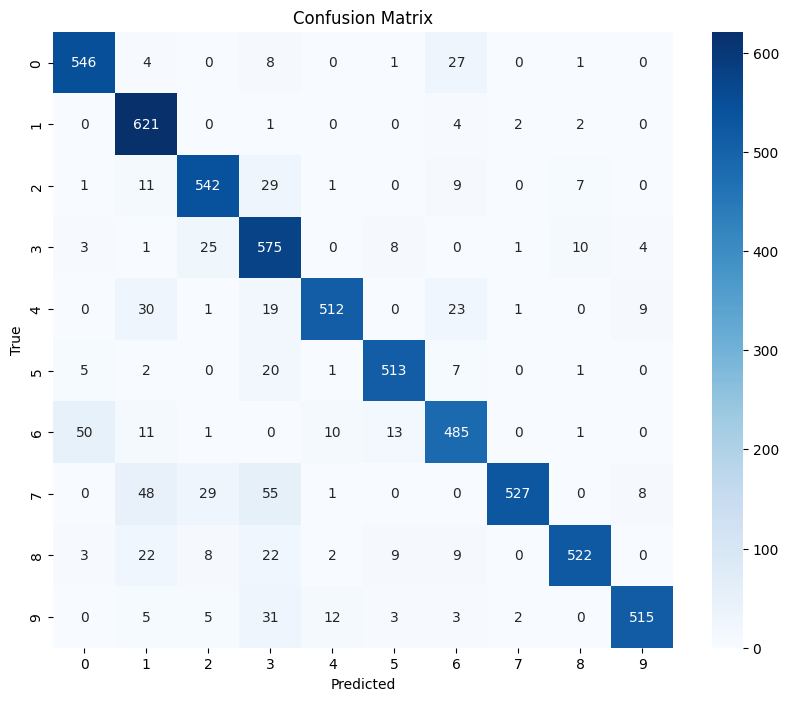

In [41]:
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        images, labels, _, _, _ = batch  
        images, labels = images.to(device), labels.to(device)
        
        # Get predictions using predict_number
        outputs = model.predict_number(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


cm = confusion_matrix(all_labels, all_preds)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Visualizing one of the sample data

In [98]:
color = (random_colors[digits_mean_color[7]] + np.random.normal(0,20,size=(3)))
color = np.clip(color,0,255)
gray = data.data[40578].float()/255.0
colored_digit = (gray.view(1,28,28)*(torch.from_numpy(color).float().view(3,1,1))/255.0)
plt.imshow(colored_digit.permute(1, 2, 0))

In [99]:
colored_digit_d=colored_digit.view(1,3,28,28).to(device)
np.argmax(model.predict_number(colored_digit_d).cpu().detach().numpy())

2

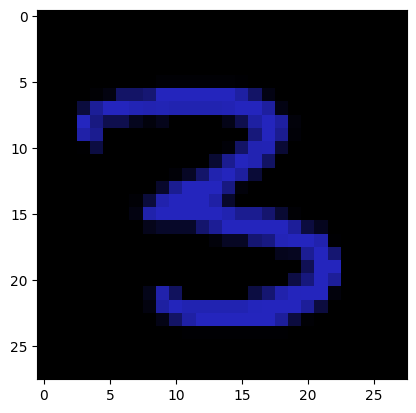